In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## EXPLANATION OF THE PARAMETERS TO BE SET:

### General identification of the experiment:
##### "exp_id"
    ID of the experiment to take into account for using its model during the inference.
    
### The following parameters must be specified according to what was considered in the original experiments to be used for the inference (according to the exp_id):


##### 1) "GSD": 
    This parameter refers to the Ground Sampling Distance of the inputs to be used. 
    
    The possible options are 30 or 300.

##### 2) "norm"
    It specifies the normalization technique to be applied:
    
    - Standard Scaling: The parameter must be set to "Standard_30" or "Standard_300" (depending the GSD of the input data), 
    - Min max scaling: If this normalization technique is desired the param must be set to "minmax_300" (just for 300 m GSD inputs), 
    - Normalization to reflectance units: the param should take the value "reflectance" (just for 300 m GSD inputs)

##### 3) "data_augm"
    Parameter which determines if data augmentation must be applied on the input data.
    
    Possible values: True or False

##### 4) "model_ml"
    This parameter is used to define the model typology to be considered. The options are "SVR" for
    selecting Support Vector Regressor model and "RF" for choosing Random Forest Regressor Model.

    For this specific notebook this parameter can also take the values LSTM and GRU (Deep learning models).

In [2]:
exp_id="RF-14" # ID of the experiment to take into account for using its model during the inference.

model_ml = "RF" # Options: RF, SVR, LSTM, GRU

data_augm = False

norm= "Standard_30" #"Standard_30","Standard_300", "minmax_300", "reflectance" 
PCA_check=False
GSD=30

In [3]:
workdir="./data/inputs/intersected_inputs/"

In [4]:
from scipy.ndimage.filters import convolve
def get_8_neighbors(img, kernel_type):
    # define the 8-neighbor kernel
    
    if kernel_type =="normal":
        kernel = np.ones((3, 3))/9
    
    if kernel_type == "sobel_x":
        kernel = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])
    if kernel_type == "sobel_y":
        kernel = np.array([[-1, -2, -1], 
                        [ 0,  0,  0], 
                        [ 1,  2,  1]])
    
    # apply convolution to obtain the 8-neighbor pixels
    neighbors = np.zeros_like(img)
    for i in range(img.shape[0]):
        neighbors[i] = convolve(img[i], kernel)
    
    # repeat the neighbors 8 times and stack them
    augmented_neighbors = np.concatenate([neighbors]*8, axis=1)
    augmented = np.concatenate([img, augmented_neighbors], axis=1)

    return augmented

def to_vector(id,limit, mode):

    if GSD==30:
        labels_ras=rio.open(workdir+f"GT_30_no_anomalies/{str(id)}.tif")

    if GSD==300:
        labels_ras=rio.open(workdir+f"GT_300_no_anomalies/{str(id)}.tif")
          
    labels_np=labels_ras.read()
        
    shape_labels=labels_np.shape  
        
    labels_np=np.moveaxis(labels_np, 0, 2)
    
    if GSD==30:
        features_ras=rio.open(workdir+f"PRS_imgs/{str(id)}.tif")
    
    if GSD==300:
        features_ras=rio.open(workdir+f"PRS_imgs_300/{str(id)}.tif")
        
    features_np=features_ras.read()
    
    features_np=features_np*(labels_np[:,:,0]!=0.)
    
    shape_features=features_np.shape
    
    features_np=features_np[:limit,:,:]
    
    if mode=="train" and data_augm:
        features_normal=get_8_neighbors(features_np, "normal")
        features_sobel_x=get_8_neighbors(features_np, "sobel_x")
        features_sobel_y=get_8_neighbors(features_np, "sobel_y")
        features_np = np.concatenate([features_normal, features_sobel_x, features_sobel_y], axis=1)
        
    features_np=np.moveaxis(features_np, 0, 2)
    
    features=np.reshape(features_np,(features_np.shape[0]*features_np.shape[1],features_np.shape[2]))
    print(features.shape)
    
    labels=np.reshape(labels_np,(labels_np.shape[0]*labels_np.shape[1],labels_np.shape[2]))
    print(labels.shape)
    
    if mode =="train" and data_augm:
        labels=np.concatenate([labels]*9*3, axis=0)
        
    return features, labels, shape_features, shape_labels 

C:\Users\juanf\AppData\Local\Temp\ipykernel_512\1673822487.py:1: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [5]:
list_test_ids= [4,23,24]

In [6]:
a=pd.DataFrame()
st_feat=[]
length=0
ids=[]
start_arr=[]
end_arr=[]
shp_arr_ft=[]
shp_arr_lbs=[]

for idx,i in enumerate(list_test_ids):
    
    features, labels, shape_features, shape_labels =to_vector(i,230,"test")
    ids.append(i)
    shp_arr_ft.append(shape_features)
    shp_arr_lbs.append(shape_labels)
    start_arr.append(length)
    length+=shape_labels[1]*shape_labels[2]
    end_arr.append(length)
    
    if idx==0:
        st_feat_test=features
        st_lbs_test=labels
    else:
        st_feat_test=np.vstack([st_feat_test,features])
        st_lbs_test=np.vstack([st_lbs_test,labels])
        
st_lbs_test = st_lbs_test.ravel()

(974400, 230)
(974400, 1)
(992000, 230)
(992000, 1)
(885000, 230)
(885000, 1)


In [7]:
df_test = pd.DataFrame(list(zip(ids, start_arr ,end_arr,shp_arr_ft, shp_arr_lbs)),
               columns =['id', 'start_idx', "end_idx","shape_features","shape_labels"])

df_test

id  start_idx  end_idx    shape_features    shape_labels
0   4          0   974400  (230, 840, 1160)  (1, 840, 1160)
1  23     974400  1966400  (230, 800, 1240)  (1, 800, 1240)
2  24    1966400  2851400  (230, 1180, 750)  (1, 1180, 750)

In [8]:
fit_stack = st_feat_test

In [9]:
if norm=="Standard_300":
    scaler=StandardScaler()
    scaler.fit(fit_stack)
    
if norm=="minmax_300":
    scaler=MinMaxScaler()
    scaler.fit(fit_stack) # calculo la media para poder hacer la transformacion

if PCA_check==True and GSD==300:
    pca = PCA(n_components=30)
    pca.fit(fit_stack)
    
if norm=="Standard_30" and PCA_check==True and GSD==30:
    # create a StandardScaler object to scale the data
    scaler = StandardScaler()
    # create an IncrementalPCA object
    n_components = 30  # set the number of principal components
    batch_size = 10000  # set the size of each batch
    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    # loop through the dataset and fit the PCA model in batches
    for X_batch in np.array_split(fit_stack, batch_size):
        # scale the batch
        scaler.partial_fit(X_batch)
        # fit the batch to the PCA model
        ipca.partial_fit(X_batch)
        
if norm=="Standard_30" and PCA_check==False and GSD==30:
    # create a StandardScaler object to scale the data
    scaler = StandardScaler()
    batch_size = 10000  # set the size of each batch
    for X_batch in np.array_split(fit_stack, batch_size):
        # scale the batch
        scaler.partial_fit(X_batch)


In [10]:
import joblib

In [11]:
if model_ml=="RF" or model_ml=="SVR":
    clf = joblib.load(f"./models/{exp_id}.joblib")
else:
    from tsai.all import *
    my_setup()
    PATH = Path(f'./models/{exp_id}.pkl')
    clf = load_learner(PATH, cpu=False)

In [12]:
X_test_scaled=scaler.transform(st_feat_test)

In [13]:
if PCA_check:
    X_test = ipca.transform(X_test_scaled)
else:
    X_test = X_test_scaled

y_test = st_lbs_test

In [14]:
if model_ml=="RF" or model_ml=="SVR":
    test_preds = clf.predict(X_test.astype("float32"))
else:
    X_test=to3d(X_test)
    test_probas, test_targets, test_preds = clf.get_X_preds(X_test, with_decoded=True)

In [15]:
preds=np.array(test_preds)

In [16]:
pred_masked=[]

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds_arr=np.array([])
mae_score=np.array([])
rmse_score=np.array([])

for i,r in df_test.iterrows():
    id_img = r.id
    start_idx=r.start_idx
    end_idx=r.end_idx
    shape_labels=r.shape_labels
    reshaped_pred=np.reshape(preds[start_idx:end_idx],shape_labels)
    
    pred_metric=reshaped_pred[0]
    gt=rio.open(f"./data/inputs/intersected_inputs/GT_30_no_anomalies/{id_img}.tif").read()[0]
    pred_masked=np.reshape((reshaped_pred[0,:,:]),(shape_labels[1]*shape_labels[2],1))

    if i==0:
        pred_mask_arr=pred_masked
        mae_score=mean_absolute_error(gt[gt!=0], pred_metric[gt!=0])
        rmse_score=mean_squared_error(gt[gt!=0], pred_metric[gt!=0], squared=False)

    else:
        pred_mask_arr=np.vstack([pred_mask_arr,pred_masked])
        mae_score=np.hstack([mae_score, mean_absolute_error(gt[gt!=0], pred_metric[gt!=0])])
        rmse_score=np.hstack([rmse_score, mean_squared_error(gt[gt!=0], pred_metric[gt!=0], squared=False)])
    
    #plt.imshow(gt)
    pred_masked2=reshaped_pred[0]*(gt!=0)
    reshaped_pred=np.expand_dims(pred_masked2,0)
    print(reshaped_pred.shape)
    meta=rio.open(f"./data/inputs/intersected_inputs/PRS_imgs/{id_img}.tif").meta
    meta["count"]=1
    with rio.open(f"./outputs_tifs/output tifs v2/30m_id_{id_img}_exp_{exp_id}.tif", mode="w", **meta) as new_dataset:
        new_dataset.write(np.clip(reshaped_pred,0,100))

(1, 840, 1160)
(1, 800, 1240)
(1, 1180, 750)


In [27]:
mae_score,mae_score.mean(), rmse_score,rmse_score.mean()

(array([0.53943897, 0.59180388, 1.99536978]),
 1.042204209587639,
 array([0.65213305, 0.79422481, 2.13917828]),
 1.1951787159355554)

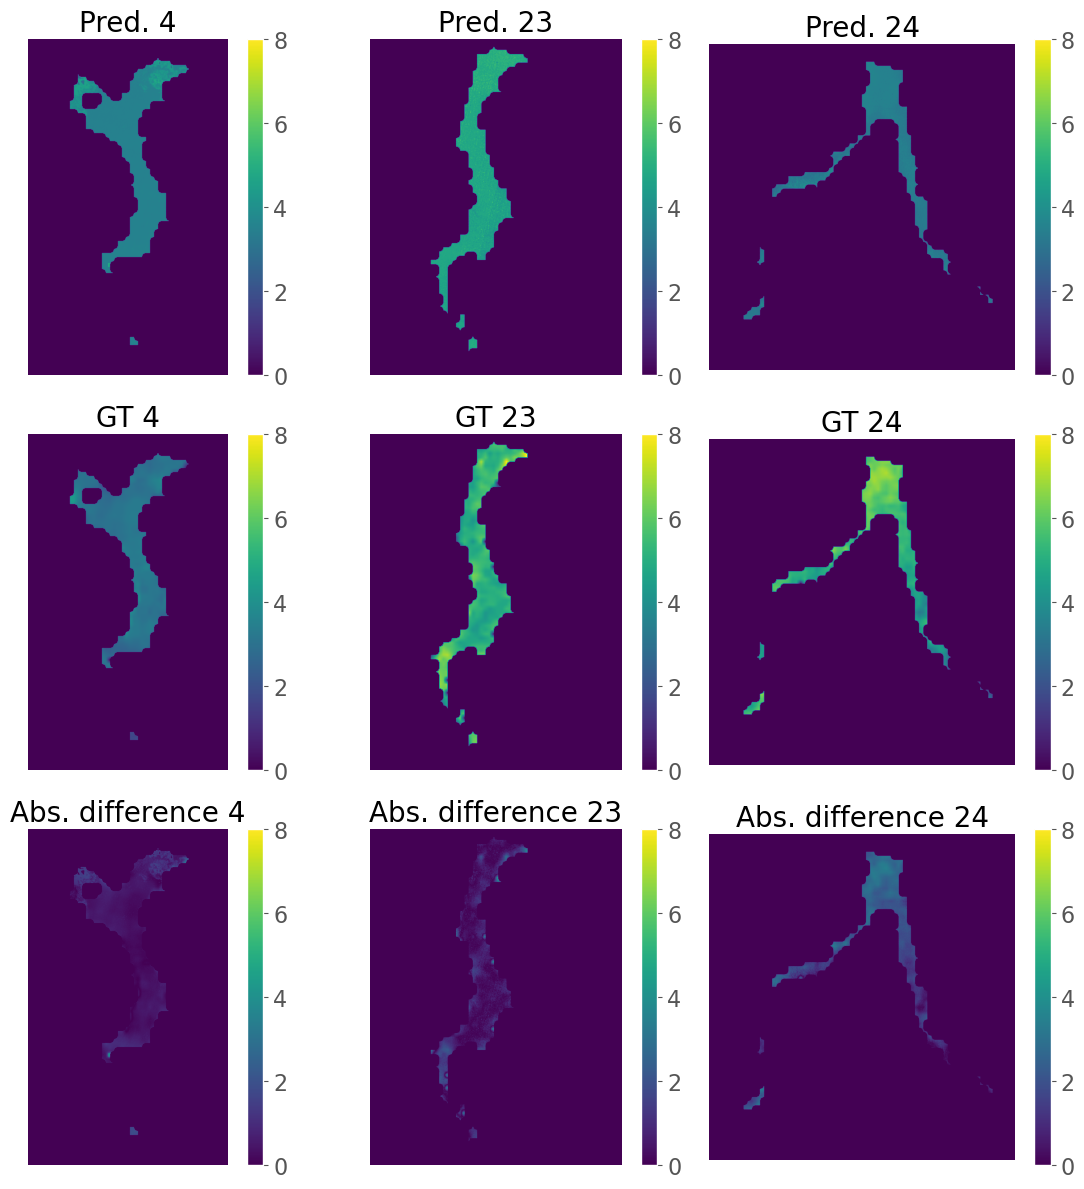

In [34]:
ls=16
fs=20

if GSD==300:

    pred1=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[0])}_exp_{exp_id}.tif").read()[0,:,:50]
    pred2=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[1])}_exp_{exp_id}.tif").read()[0,:,:60]
    pred3=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[2])}_exp_{exp_id}.tif").read()[0,:80,:]
    
    gt1=rio.open(f"./data/inputs/intersected_inputs/GT_300_no_anomalies/{str(list_test_ids[0])}.tif").read()[0,:,:50]
    gt2=rio.open(f"./data/inputs/intersected_inputs/GT_300_no_anomalies/{str(list_test_ids[1])}.tif").read()[0,:,:60]
    gt3=rio.open(f"./data/inputs/intersected_inputs/GT_300_no_anomalies/{str(list_test_ids[2])}.tif").read()[0,:80,:]

if GSD==30:

    pred1=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[0])}_exp_{exp_id}.tif").read()[0,:,:500]
    pred2=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[1])}_exp_{exp_id}.tif").read()[0,:,:600]
    pred3=rio.open(f"./outputs_tifs/output tifs v2/id_{str(list_test_ids[2])}_exp_{exp_id}.tif").read()[0,:800,:]

    gt1=rio.open(f"./data/inputs/intersected_inputs/GT_30_no_anomalies/{str(list_test_ids[0])}.tif").read()[0,:,:500]
    gt2=rio.open(f"./data/inputs/intersected_inputs/GT_30_no_anomalies/{str(list_test_ids[1])}.tif").read()[0,:,:600]
    gt3=rio.open(f"./data/inputs/intersected_inputs/GT_30_no_anomalies/{str(list_test_ids[2])}.tif").read()[0,:800,:]

    
dif1=abs(gt1-pred1)
dif2=abs(gt2-pred2)
dif3=abs(gt3-pred3)

plt.figure(figsize=[12,12])

plt.subplot(3,3,1)
im1 =plt.imshow(pred1*(gt1!=0), vmax=8)
plt.title(f"Pred. {str(list_test_ids[0])}", fontsize=fs)
cbar1 = plt.colorbar(im1)
cbar1.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,2)
im2 =plt.imshow(pred2*(gt2!=0), vmax=8)
plt.title(f"Pred. {str(list_test_ids[1])}", fontsize=fs)
cbar2 = plt.colorbar(im2)
cbar2.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,3)
im3 =plt.imshow(pred3*(gt3!=0), vmax=8)
plt.title(f"Pred. {str(list_test_ids[2])}", fontsize=fs)
cbar3 = plt.colorbar(im3)
cbar3.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,4)
im4 = plt.imshow(gt1, vmax=8)
plt.title(f"GT {str(list_test_ids[0])}", fontsize=fs)
cbar4 = plt.colorbar(im4)
cbar4.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,5)
im5 = plt.imshow(gt2, vmax=8)
plt.title(f"GT {str(list_test_ids[1])}", fontsize=fs)
cbar5 = plt.colorbar(im5)
cbar5.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,6)
im6 = plt.imshow(gt3, vmax=8)
plt.title(f"GT {str(list_test_ids[2])}", fontsize=fs)
cbar6 = plt.colorbar(im6)
cbar6.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,7)
im7 = plt.imshow(dif1*(gt1!=0), vmax=8)
plt.title(f"Abs. difference {str(list_test_ids[0])}", fontsize=fs)
cbar7 = plt.colorbar(im7)
cbar7.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,8)
im8 = plt.imshow(dif2*(gt2!=0), vmax=8)
plt.title(f"Abs. difference {str(list_test_ids[1])}", fontsize=fs)
cbar8 = plt.colorbar(im8)
cbar8.ax.tick_params(labelsize=ls)
plt.axis('off')

plt.subplot(3,3,9)
im9 = plt.imshow(dif3*(gt3!=0), vmax=8)
plt.title(f"Abs. difference {str(list_test_ids[2])}", fontsize=fs)
cbar9 = plt.colorbar(im9)
cbar9.ax.tick_params(labelsize=ls)
plt.axis('off') 

plt.tight_layout()

plt.savefig(f"./output_results/results_{exp_id}_maps.jpg")

C:\Users\juanf\AppData\Local\Temp\ipykernel_512\3689603462.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


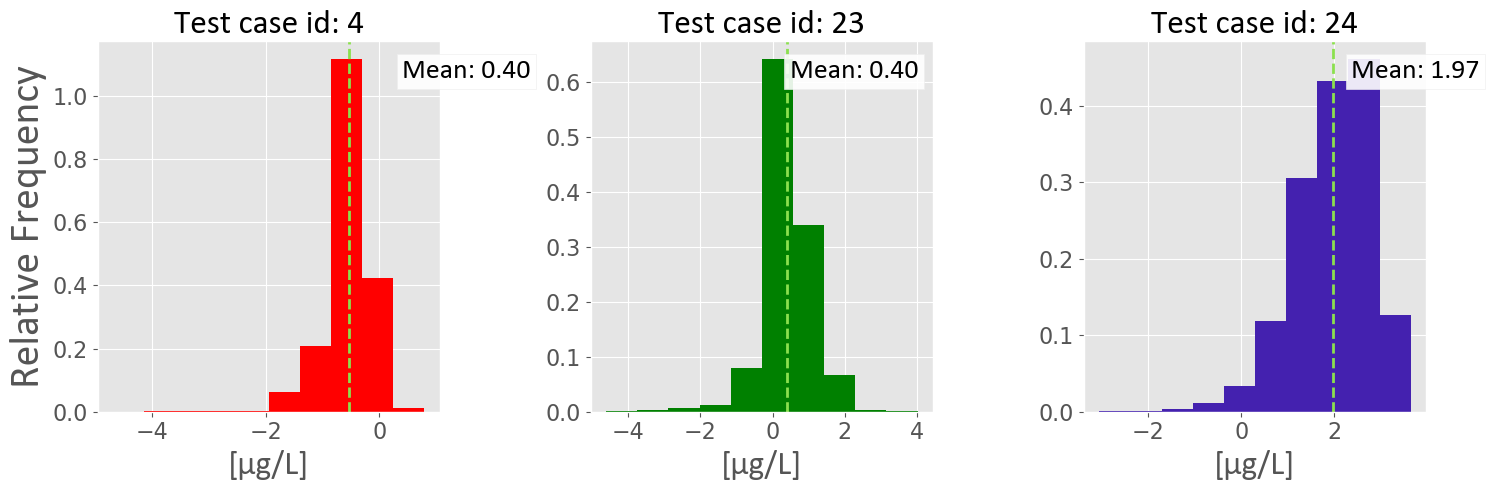

In [35]:
plt.style.use('ggplot')

fs=24

dif1_check=(gt1-pred1)*(gt1!=0)
dif1_check=dif1_check[dif1_check!=0]

dif2_check=(gt2-pred2)*(gt2!=0)
dif2_check=dif2_check[dif2_check!=0]

dif3_check=(gt3-pred3)*(gt3!=0)
dif3_check=dif3_check[dif3_check!=0]

plt.figure(figsize=[15,5])

plt.tick_params(axis='both', which='major', labelsize=25)

plt.subplot(1,3,1)
plt.hist(dif1_check, color="red", density=True)
plt.title("Test case id: 4",fontsize=fs, fontname="Calibri")
plt.axvline(dif1_check.mean(), color="#8be04e", linestyle='dashed', linewidth=2)
plt.xlabel("[µg/L]", fontname='Calibri', fontsize=24)
plt.ylabel("Relative Frequency", fontname='Calibri', fontsize=30)
min_ylim, max_ylim = plt.ylim()
plt.text(dif2_check.mean(), max_ylim*0.9 , 'Mean: {:.2f}'.format(dif2_check.mean()), bbox=dict(facecolor='white', alpha=0.9), fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(1,3,2)
plt.hist(dif2_check, color="green", density=True)
plt.title("Test case id: 23",fontsize=fs, fontname="Calibri")
plt.xlabel("[µg/L]", fontname='Calibri', fontsize=24)
plt.axvline(dif2_check.mean(), color="#8be04e", linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(dif2_check.mean()*1.2, max_ylim*0.9 , 'Mean: {:.2f}'.format(dif2_check.mean()), bbox=dict(facecolor='white', alpha=0.9), fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.subplot(1,3,3)
plt.hist(dif3_check, color="#4421af", density=True)
plt.title("Test case id: 24",fontsize=fs, fontname="Calibri")
plt.xlabel("[µg/L]", fontname='Calibri', fontsize=24)
plt.axvline(dif3_check.mean(), color="#8be04e", linestyle='dashed', linewidth=2)
min_ylim, max_ylim = plt.ylim()
plt.text(dif3_check.mean()*1.2, max_ylim*0.9 , 'Mean: {:.2f}'.format(dif3_check.mean()), bbox=dict(facecolor='white', alpha=0.9), fontname="Calibri", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()

plt.savefig(f"./output_results/results_{exp_id}.jpg")